# Data Understanding



In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy
import psycopg2
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [2]:
engine = sqlalchemy.engine.create_engine('sqlite:///./data/database.sqlite')
engine.table_names()

['resultsdata13', 'sampledata13']

In [3]:
con = engine.connect()

In [4]:
untest = con.execute('SELECT * FROM sampledata13')
untested = pd.DataFrame(data=untest.fetchall(), columns=untest.keys())
untested.head()
untested.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10104 entries, 0 to 10103
Data columns (total 18 columns):
sample_pk    10104 non-null int64
state        10104 non-null object
year         10104 non-null object
month        10104 non-null object
day          10104 non-null object
site         10104 non-null object
commod       10104 non-null object
source_id    10104 non-null object
variety      10104 non-null object
origin       10104 non-null object
country      10104 non-null object
disttype     10104 non-null object
commtype     10104 non-null object
claim        10104 non-null object
quantity     10104 non-null object
growst       10104 non-null object
packst       10104 non-null object
distst       10104 non-null object
dtypes: int64(1), object(17)
memory usage: 1.4+ MB


In [5]:
query = '''SELECT sample_pk
, state
, origin
, disttype
FROM sampledata13
JOIN resultsdata13
ON sampledata13.sample_pk = resultsdata13.sample_pk'''

In [6]:
mega = con.execute(query)
mega_df = pd.DataFrame(data=mega.fetchall(), columns=mega.keys())
mega.head()

OperationalError: (sqlite3.OperationalError) ambiguous column name: sample_pk
[SQL: SELECT sample_pk
, state
, origin
, disttype
FROM sampledata13
JOIN resultsdata13
ON sampledata13.sample_pk = resultsdata13.sample_pk]
(Background on this error at: http://sqlalche.me/e/e3q8)

OG

In [7]:
result = con.execute('SELECT * FROM resultsdata13')
results = pd.DataFrame(data=result.fetchall(), columns=result.keys())
results.head()

,sample_pk,commod,commtype,lab,pestcode,testclass,concen,lod,conunit,confmethod,confmethod2,annotate,quantitate,mean,extract,determin
0,1,AJ,RE,WA1,540,A,,0.002,M,,,,,ND,805,35\r\n
1,1,AJ,RE,WA1,562,C,,0.001,M,,,,,ND,805,52\r\n
2,1,AJ,RE,WA1,594,F,,0.005,M,,,,,ND,805,52\r\n
3,1,AJ,RE,WA1,596,A,,0.002,M,,,,,ND,805,52\r\n
4,1,AJ,RE,WA1,597,O,,0.010,M,,,,,ND,805,35\r\n


In [8]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023087 entries, 0 to 2023086
Data columns (total 16 columns):
sample_pk      int64
commod         object
commtype       object
lab            object
pestcode       object
testclass      object
concen         object
lod            float64
conunit        object
confmethod     object
confmethod2    object
annotate       object
quantitate     object
mean           object
extract        object
determin       object
dtypes: float64(1), int64(1), object(14)
memory usage: 247.0+ MB


# Data Understanding

## Drop irrelevant attributes that are only about lab testing methods: `confmethod`, `confmethod2`, and `testclass`.

In [9]:
irrelevant = ['confmethod', 'confmethod2', 'testclass']

In [10]:
results.drop(irrelevant, axis=1, inplace=True)

In [11]:
results.head()

,sample_pk,commod,commtype,lab,pestcode,concen,lod,conunit,annotate,quantitate,mean,extract,determin
0,1,AJ,RE,WA1,540,,0.002,M,,,ND,805,35\r\n
1,1,AJ,RE,WA1,562,,0.001,M,,,ND,805,52\r\n
2,1,AJ,RE,WA1,594,,0.005,M,,,ND,805,52\r\n
3,1,AJ,RE,WA1,596,,0.002,M,,,ND,805,52\r\n
4,1,AJ,RE,WA1,597,,0.010,M,,,ND,805,35\r\n


# Data Preparation

In [12]:
results['annotate'].value_counts()

      2018200
Q        4533
V         186
QV        145
X          23
Name: annotate, dtype: int64

In [13]:
results.isnull().sum()

sample_pk     0
commod        0
commtype      0
lab           0
pestcode      0
concen        0
lod           0
conunit       0
annotate      0
quantitate    0
mean          0
extract       0
determin      0
dtype: int64

In [14]:
results['annotate'][0] == ''

True

Notice our target attribute has many missing values, encoded as empty strings rather than null values. We drop those. 

In [15]:
results = results[results['annotate'] != '']
results.head()

,sample_pk,commod,commtype,lab,pestcode,concen,lod,conunit,annotate,quantitate,mean,extract,determin
50238,239,AJ,RE,WA1,083,0.008,0.005,M,Q,,O,805,35\r\n
249096,1183,BR,FR,FL1,AFU,0.011,0.010,M,V,,O,805,52\r\n
251475,1196,BR,FR,FL1,AFU,0.013,0.010,M,V,,O,805,52\r\n
257567,1230,BR,FR,FL1,144,0.035,0.005,M,V,,O,805,35\r\n
264693,1269,BR,FR,FL1,180,0.026,0.010,M,V,,O,805,52\r\n


Mean is a terrible name for a column, so we'll rename it.

In [16]:
results.rename(columns={'mean':'avg_detect'}, inplace=True)
results.head()

,sample_pk,commod,commtype,lab,pestcode,concen,lod,conunit,annotate,quantitate,avg_detect,extract,determin
50238,239,AJ,RE,WA1,083,0.008,0.005,M,Q,,O,805,35\r\n
249096,1183,BR,FR,FL1,AFU,0.011,0.010,M,V,,O,805,52\r\n
251475,1196,BR,FR,FL1,AFU,0.013,0.010,M,V,,O,805,52\r\n
257567,1230,BR,FR,FL1,144,0.035,0.005,M,V,,O,805,35\r\n
264693,1269,BR,FR,FL1,180,0.026,0.010,M,V,,O,805,52\r\n


In [17]:
results.shape

(4887, 13)

In [18]:
for col in results.columns:
    print(results[col].value_counts())

9656    12
9912    12
9657    11
9679    11
9924    10
9677    10
9675    10
9883    10
9670     9
9662     9
9914     9
9646     9
9896     9
9916     9
9655     9
9923     9
4349     9
9663     9
9673     9
9681     8
3175     8
9686     8
9661     8
9688     8
9910     8
2638     8
9667     8
9660     8
9901     8
9899     8
        ..
2976     1
2326     1
2951     1
7086     1
2964     1
2318     1
7045     1
2996     1
2314     1
3000     1
7037     1
7062     1
7058     1
9021     1
2971     1
6978     1
2979     1
6986     1
2006     1
7002     1
7069     1
7026     1
2960     1
9483     1
2936     1
7061     1
2944     1
7050     1
7054     1
7134     1
Name: sample_pk, Length: 2324, dtype: int64
BU    1127
CR     949
CE     834
NE     752
WR     312
WU     291
WS     177
CF     171
IA     120
RS      37
GB      26
SS      20
RZ      14
BR      13
WG      13
PU      12
MU      12
PC       5
GJ       1
AJ       1
Name: commod, dtype: int64
FR    3624
RE    1128
PU     120
FZ   

## `quantitate` column has many missing values, so we'll drop it.

In [21]:
results.drop(['quantitate'], axis=1, inplace=True)
results.head()

KeyError: "['quantitate'] not found in axis"

In [20]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4887 entries, 50238 to 1967810
Data columns (total 12 columns):
sample_pk     4887 non-null int64
commod        4887 non-null object
commtype      4887 non-null object
lab           4887 non-null object
pestcode      4887 non-null object
concen        4887 non-null object
lod           4887 non-null float64
conunit       4887 non-null object
annotate      4887 non-null object
avg_detect    4887 non-null object
extract       4887 non-null object
determin      4887 non-null object
dtypes: float64(1), int64(1), object(10)
memory usage: 496.3+ KB


### Converting data types. `sample_pk` is a unique value, it will remain a string. `concen` is in parts/million, parts/billion, and parts/trillion, depending on its corresponding value for `conunit`. We make new column with the numerical value of the `concentration`.

In [23]:
results['concentration'] = results.concen.astype(float)

results.loc[results['conunit'] == 'M', 'concentration'] *= 10e6
results.loc[results['conunit'] == 'B', 'concentration'] *= 10e9
results.loc[results['conunit'] == 'T', 'concentration'] *= 10e12

Now `concen` and `conunit` are redundant and misleading, so we'll drop them.

In [24]:
results.drop(['concen', 'conunit'], axis=1, inplace=True)
results.head()

,sample_pk,commod,commtype,lab,pestcode,lod,annotate,avg_detect,extract,determin,concentration
50238,239,AJ,RE,WA1,083,0.005,Q,O,805,35\r\n,80000.0
249096,1183,BR,FR,FL1,AFU,0.010,V,O,805,52\r\n,110000.0
251475,1196,BR,FR,FL1,AFU,0.010,V,O,805,52\r\n,130000.0
257567,1230,BR,FR,FL1,144,0.005,V,O,805,35\r\n,350000.0
264693,1269,BR,FR,FL1,180,0.010,V,O,805,52\r\n,260000.0


Let's take a look at the distribution of our target variable, `annotate`

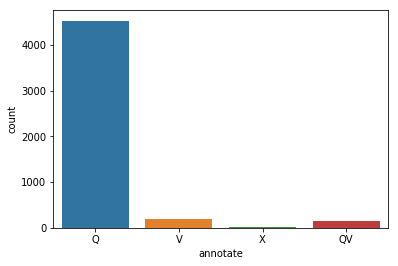

In [27]:
sns.countplot(x=results['annotate'], data=results)

This distribution is not normal.

In [28]:
from imblearn.over_sampling import SMOTE

In [31]:
smote = SMOTE('not majority')
smote.fit(results)

TypeError: fit() missing 1 required positional argument: 'y'

This looks great, so we'll export as a csv.

In [ ]:
cleaned_data = results.to_csv('data/cleaned_data.csv')